In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics

In [3]:
HousePrices = pd.read_csv('data/train.csv')
cleaned_hp = pd.read_csv('data/cleaned_houseprice.csv')

y = np.log(HousePrices['SalePrice'])
X = cleaned_hp.drop('Id',axis = 1)

X.head()

,CentralAir,HeatingQC,garage_score,Heating,Electrical,GarageArea,TotalBsmtSF,finishedbsmt,2Types,Basment,...,Ext_Stucco,Ext_WdSdng,Ext_WdShing,House_1.5Fin,House_1.5Unf,House_2.5Fin,House_2.5Unf,House_2Story,House_SFoyer,House_SLvl
0,1,5,6,1,5,548,856,0.824766,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,5,6,1,5,460,1262,0.774960,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,5,6,1,5,608,920,0.528261,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,4,6,1,5,642,756,0.285714,0,0,...,0,1,0,0,0,0,0,1,0,0
4,1,5,6,1,5,836,1145,0.572052,0,0,...,0,0,0,0,0,0,0,1,0,0


### Basic MLR

In [4]:
ols = linear_model.LinearRegression()

In [5]:
#TrainTestSplit:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
ols.fit(X_train, y_train)
print(ols.score(X_train, y_train))
print(ols.score(X_test, y_test))

0.9025067932099374
0.9020364716608223


### Basic MLR + log transform features that are skewed
- proof that normalizing improves score (R^2) 

In [6]:
all_cols = X.columns
lis_ = []

for col in all_cols:
    if len(X[col].unique()) == 2:
        continue
    else: 
        lis_.append(col)

In [7]:
pos_skewed_feats =[]
neg_skewed_feats =[]

for col in lis_:
    if (X[col].skew() > 0.75):
        pos_skewed_feats.append(col)
#     if (X[col].skew() < -0.75):
#         neg_skewed_feats.append(col)

print(pos_skewed_feats)

['TotalBsmtSF', 'GrLivArea', 'LotArea', 'LotShape', 'LandSlope', 'EnclosedPorch', 'Total_PorchDeckSF']


In [8]:
X2 = X.copy()

for col in all_cols:
    if col in pos_skewed_feats:
        X2[col] = np.log1p(X2[col])
#     elif col in neg_skewed_feats: 
#         X2[col] = np.sqrt(X2[col])
#     else:
#         continue 

In [9]:
for col in pos_skewed_feats:
    print(col)
    print(X[col].skew())
    print(X2[col].skew())

TotalBsmtSF
1.5242545490627664
-5.1546699835179135
GrLivArea
1.3665603560164552
-0.006140253486287281
LotArea
12.207687851233496
-0.13740448122837784
LotShape
1.309985656555955
0.7831035648282987
LandSlope
4.813682424489448
4.297167061742489
EnclosedPorch
3.08987190371177
2.1122749483873156
Total_PorchDeckSF
1.225027362577339
-0.9021319607191441


In [10]:
#TrainTestSplit:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y, test_size=0.3, random_state=42)
ols.fit(X2_train, y_train)
print(ols.score(X2_train, y2_train))
print(ols.score(X2_test, y2_test))

0.9129721165287057
0.9145201447514633


### Elastic Net 

In [11]:
from sklearn.linear_model import ElasticNetCV, ElasticNet

In [78]:
en_model = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=1)

en_model.fit(X2_train, y_train)
print(en_model.alpha_)
print(en_model.l1_ratio_)
print(en_model.n_iter_)

0.00013029036686063448
0.9
41


In [79]:
y_train_pred = en_model.predict(X2_train)
y_pred = en_model.predict(X2_test)

print(metrics.r2_score(y_train_pred, y_train))
print(metrics.r2_score(y_test, y_pred))

print(np.sqrt(metrics.mean_squared_error(y_train_pred, y_train)))
print(np.sqrt(metrics.mean_squared_error(y_pred, y_test)))

0.8882697894981805
0.9172204578950744
0.12165863369917053
0.11850414278852817


- Looks like doing an Elastic Net on log transformed(X2) performs better than the previous models
- Feature Importance from ElasticNet

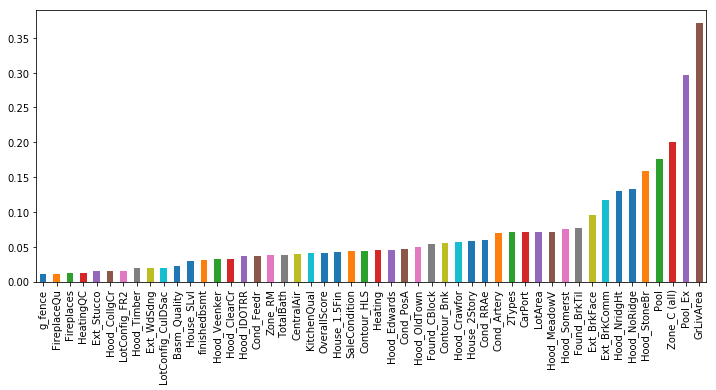

In [14]:
feature_importance = pd.Series(index=X2_train.columns, data=np.abs(en_model.coef_))
feature_importance.sort_values(ascending=True).tail(50).plot(kind='bar', figsize=(12,5))


### Against Vincent adj Sales Price

In [96]:
HousePrices_adj = pd.read_csv('SalePriceAdj.csv')

y_adj = HousePrices_adj.drop(['Unnamed: 0','Id'], axis=1)
y_adj =  np.log(HousePrices_adj['SalePrice_Adj'])

In [97]:
Xadj_train, Xadj_test, yadj_train, yadj_test = train_test_split(X2, y_adj, test_size=0.3, random_state=42)


In [98]:
en_model_adj = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=1)

en_model_adj.fit(Xadj_train, yadj_train)
print(en_model_adj.alpha_)
print(en_model_adj.l1_ratio_)
print(en_model_adj.n_iter_)

0.00013895529405860073
0.9
42


In [99]:
yadj_train_pred = en_model_adj.predict(Xadj_train)
yadj_pred = en_model_adj.predict(Xadj_test)

print(metrics.r2_score(yadj_train_pred, yadj_train))
print(metrics.r2_score(yadj_test, yadj_pred))

print(np.sqrt(metrics.mean_squared_error(yadj_train_pred, yadj_train)))
print(np.sqrt(metrics.mean_squared_error(yadj_pred, yadj_test)))

0.8845275755585265
0.9139938641918418
0.12398173681179189
0.1212687396554152


### Try limiting the features to anything above 0.05

In [22]:
feat_importance = feature_importance.sort_values(ascending=True).tail(80)

top_feat = feat_importance[feat_importance > 0.01]
top_feat

top_feat_list = []
for colname in top_feat.index:
    top_feat_list.append(colname)


In [83]:
len(feat_importance[feat_importance > 0])

68

In [23]:
X21 = X2[top_feat_list]

X_train21, X_test21, y_train21, y_test21  = train_test_split(X21, y, test_size = 0.2, random_state = 0)
en_model_tf = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

en_model_tf.fit(X_train21, y_train21)
print(en_model_tf.alpha_)
print(en_model_tf.l1_ratio_)
print(en_model_tf.n_iter_)

1.723598070459207e-05
0.5
27


In [24]:
y_train_pred21 = en_model_tf.predict(X_train21)
y_pred21 = en_model_tf.predict(X_test21)

print(metrics.r2_score(y_train_pred21, y_train21))
print(metrics.r2_score(y_test21, y_pred21))

print(np.sqrt(metrics.mean_squared_error(y_train_pred21, y_train21)))
print(np.sqrt(metrics.mean_squared_error(y_pred21, y_test21)))

0.9095118989400626
0.8363342444287193
0.11515581181971075
0.15741337146387252


### Use elastic net feature output to perform ridge regression at different cut off points

In [70]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge

In [76]:
cutoffs = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25]
ridge = Ridge()
parameters = {'alpha':[1e-15, 1e-10, 1e-8, 1e-4, 1e-3, 1e-2, 1, 5, 10, 20]}
ridge.set_params(normalize=False)
ridge_regressor = GridSearchCV(ridge, parameters, cv=10)


for cutoff in cutoffs: 
    tf = feat_importance[feat_importance > cutoff]
    new_df = X2[list(tf.index)]
    
    ridge_regressor.fit(new_df, y)
    print(f"Cutoff: {cutoff}")
    print(f"Best Alpha: {ridge_regressor.best_params_}")
    print(f"Score R^2: {ridge_regressor.best_score_}")
    
    predictions_new = cross_val_predict(ridge, new_df, y, cv=10)
    RMSE_new = np.sqrt(metrics.mean_squared_error(y, predictions_new))
    
    print(f"RMSE: {RMSE_new}")
    

Cutoff: 0.01
Best Alpha: {'alpha': 5}
Score R^2: 0.8961397487865038
RMSE: 0.12874584269351722
Cutoff: 0.05
Best Alpha: {'alpha': 1}
Score R^2: 0.7444041839613676
RMSE: 0.20049700848312
Cutoff: 0.1
Best Alpha: {'alpha': 1}
Score R^2: 0.6217798856366141
RMSE: 0.24413718578798746
Cutoff: 0.15
Best Alpha: {'alpha': 1}
Score R^2: 0.5565744025263872
RMSE: 0.2642505020006516
Cutoff: 0.2
Best Alpha: {'alpha': 1}
Score R^2: 0.5431162362510931
RMSE: 0.26842520765154837
Cutoff: 0.25
Best Alpha: {'alpha': 5}
Score R^2: 0.5242771144040747
RMSE: 0.27383562843054743


### Elastic Net - Dummify Month, Year on X2

In [38]:
X2['YrSold'].value_counts()

2009    338
2007    329
2006    314
2008    304
2010    175
Name: YrSold, dtype: int64

In [52]:
#Dummifying Month 
# x = pd.get_dummies(sunny_cols['Exterior1st']).drop(['VinylSd'], axis='columns')
# sunny_cols1 = sunny_cols.merge(x, left_index=True, right_index=True)

mo_dummies = pd.get_dummies(X2['MoSold']).drop([6],axis='columns')
yr_dummies = pd.get_dummies(X2['YrSold']).drop([2006],axis='columns')

X3 = X2.drop(['MoSold', 'YrSold'], axis='columns')
X4 = X3.merge(mo_dummies, left_index=True, right_index=True)
X5 = X4.merge(yr_dummies, left_index=True, right_index=True)

In [53]:
X5_train, X5_test, y5_train, y5_test = train_test_split(X5, y, test_size=0.3, random_state=42)


In [54]:
en_model_dummies = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, 1], eps=1e-3, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=2000, tol=0.0001, cv=6, 
                        copy_X=True, verbose=0, n_jobs=-1, positive=False, random_state=0)

en_model_dummies.fit(X5_train, y5_train)
print(en_model_dummies.alpha_)
print(en_model_dummies.l1_ratio_)
print(en_model_dummies.n_iter_)

0.00013029036686063448
0.9
42


In [55]:
y_train_pred_dummies = en_model_dummies.predict(X5_train)
y_pred_dummies = en_model_dummies.predict(X5_test)

print(metrics.r2_score(y_train_pred_dummies, y5_train))
print(metrics.r2_score(y5_test, y_pred_dummies))

print(np.sqrt(metrics.mean_squared_error(y_train_pred_dummies, y5_train)))
print(np.sqrt(metrics.mean_squared_error(y5_test, y_pred_dummies)))

0.8885874203621961
0.9170556905761649
0.12149171069602724
0.11862202157193738


### XGBoost

In [65]:
from xgboost import XGBRegressor, plot_importance 

In [66]:
#Not better than Elastic Net?? 
xgb_model1 = XGBRegressor()
xgb_model1.fit(X2_train, y_train, verbose=False)
y_train_pred1 = xgb_model1.predict(X2_train)
y_pred1 = xgb_model1.predict(X2_test)

print('Train r2 score: ', metrics.r2_score(y_train_pred1, y_train))
print('Test r2 score: ', metrics.r2_score(y_test, y_pred1))
train_mse1 = metrics.mean_squared_error(y_train_pred1, y_train)
test_mse1 = metrics.mean_squared_error(y_pred1, y_test)
train_rmse1 = np.sqrt(train_mse1)
test_rmse1 = np.sqrt(test_mse1)
print('Train RMSE: %.4f' % train_rmse1)
print('Test RMSE: %.4f' % test_rmse1)

/Users/YunseonLee/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:33:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9447330410617817
Test r2 score:  0.8922033556382378
Train RMSE: 0.0885
Test RMSE: 0.1352


In [67]:
#Adding a learning rate

xgb_model3 = XGBRegressor(n_estimators=1000, learning_rate=0.05)
xgb_model3.fit(X_train, y_train, early_stopping_rounds=5, 
             eval_set=[(X_test, y_test)], verbose=False)
y_train_pred3 = xgb_model3.predict(X_train)
y_pred3 = xgb_model3.predict(X_test)

print('Train r2 score: ', metrics.r2_score(y_train_pred3, y_train))
print('Test r2 score: ', metrics.r2_score(y_test, y_pred3))
train_mse3 = metrics.mean_squared_error(y_train_pred3, y_train)
test_mse3 = metrics.mean_squared_error(y_pred3, y_test)
train_rmse3 = np.sqrt(train_mse3)
test_rmse3 = np.sqrt(test_mse3)
print('Train RMSE: %.4f' % train_rmse3)
print('Test RMSE: %.4f' % test_rmse3)


/Users/YunseonLee/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[15:33:18] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train r2 score:  0.9470911333381173
Test r2 score:  0.8980682656434935
Train RMSE: 0.0865
Test RMSE: 0.1315
